# PROYECTO FINAL

# CURSO: REDES NEURONALES Y APRENDIZAJE PROFUNDO (MIA-203)

# PROFESOR: ALDO CAMARGO

# TEMA: SISTEMA DE IDENTIFICACION DE MEDIDAS CORPORALES A TRAVÉS DE IMAGENES USANDO CNN

#Grupo #2:
#Integrantes:
#- Benitez Altamirano, Bernie Hans
#- Diaz Cabrera, Alexander Gabriel
#- Morales Ccasa, Geyson David
#- Ramirez Ucañay, Barbarita Paula Janeth
#- Aldo Daniel Siu Siu Ting

##Paso #1: Importar y activar librerias

In [1]:
!pip install tensorflow
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab.patches import cv2_imshow  # Importa cv2_imshow desde google.colab.patches
from PIL import Image
from skimage import io  # Importar la función io de skimage
from sklearn.metrics import mean_absolute_error, mean_squared_error

##Paso #3: Conectar a base de datos en Google Drive

In [3]:
import zipfile

# Path to your zip file
zip_path = '/content/BodyM_dataset.zip'  # Update this path

# Extraction path
extract_path = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Paso #4: Ver estructura de datos

In [2]:
# Base directory
base_dir = '/content/BodyM_dataset'

# Train data paths
train_dir = f'{base_dir}/train'
train_subject_to_photo_map = f'{train_dir}/subject_to_photo_map.csv'
train_hwg_metadata = f'{train_dir}/hwg_metadata.csv'
train_measurements = f'{train_dir}/measurements.csv'
train_mask_dir = f'{train_dir}/mask'
train_mask_left_dir = f'{train_dir}/mask_left'

# TestA data paths
testA_dir = f'{base_dir}/testA'
testA_subject_to_photo_map = f'{testA_dir}/subject_to_photo_map.csv'
testA_hwg_metadata = f'{testA_dir}/hwg_metadata.csv'
testA_measurements = f'{testA_dir}/measurements.csv'
testA_mask_dir = f'{testA_dir}/mask'
testA_mask_left_dir = f'{testA_dir}/mask_left'

# TestB data paths
testB_dir = f'{base_dir}/testB'
testB_subject_to_photo_map = f'{testB_dir}/subject_to_photo_map.csv'
testB_hwg_metadata = f'{testB_dir}/hwg_metadata.csv'
testB_measurements = f'{testB_dir}/measurements.csv'
testB_mask_dir = f'{testB_dir}/mask'
testB_mask_left_dir = f'{testB_dir}/mask_left'

In [3]:
# Load train data CSVs
train_subject_to_photo_df = pd.read_csv(train_subject_to_photo_map)
train_hwg_metadata_df = pd.read_csv(train_hwg_metadata)
train_measurements_df = pd.read_csv(train_measurements)

# Load testA data CSVs
testA_subject_to_photo_df = pd.read_csv(testA_subject_to_photo_map)
testA_hwg_metadata_df = pd.read_csv(testA_hwg_metadata)
testA_measurements_df = pd.read_csv(testA_measurements)

# Load testB data CSVs
testB_subject_to_photo_df = pd.read_csv(testB_subject_to_photo_map)
testB_hwg_metadata_df = pd.read_csv(testB_hwg_metadata)
testB_measurements_df = pd.read_csv(testB_measurements)

In [4]:
# Merge data on 'subject_id' to get photo_id, height, weight, and body measurements in one DataFrame
train_data = train_subject_to_photo_df.merge(train_hwg_metadata_df, on='subject_id').merge(train_measurements_df, on='subject_id')

In [5]:
# Define paths for images using Google Drive paths
train_data['frontal_image_path'] = train_mask_dir + '/' + train_data['photo_id'] + '.png'
train_data['lateral_image_path'] = train_mask_left_dir + '/' + train_data['photo_id'] + '.png'

# Define additional inputs and target labels
additional_inputs = train_data[['height_cm', 'weight_kg']].values  # height and weight
target_labels = train_data[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                            'height', 'hip', 'leg-length', 'shoulder-breadth',
                            'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import LearningRateScheduler

# Image input (combined frontal and lateral as 2 channels)
image_input = Input(shape=(224, 224, 2))

# ResNet base model for image processing
resnet_base = ResNet50(include_top=False, weights=None, input_tensor=image_input)
x = Flatten()(resnet_base.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Additional input (height and weight)
additional_input = Input(shape=(2,))
y = Dense(64, activation='relu')(additional_input)

# Combine image features and additional inputs
combined = Concatenate()([x, y])
z = Dense(512, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(14, activation='linear')(z)  # 14 outputs for body measurements

# Define the model
model = Model(inputs=[image_input, additional_input], outputs=output)

# Define an exponential decay learning rate schedule with warmup
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='loss',      # Monitorea la pérdida de validación
    factor=0.5,              # Factor por el cual se reducirá la tasa de aprendizaje (nueva_lr = lr * factor)
    patience=50,              # Número de épocas sin mejora para reducir la tasa de aprendizaje
    min_lr=1e-6              # Tasa de aprendizaje mínima
)

def data_generator(data, batch_size=32, target_size=(224, 224)):
    while True:
        for start in range(0, len(data), batch_size):
            end = min(start + batch_size, len(data))
            batch_data = data[start:end]

            images = []
            additional_inputs = []
            labels = []

            for _, row in batch_data.iterrows():
                if os.path.exists(row['frontal_image_path']) and os.path.exists(row['lateral_image_path']):
                    # Cargar y procesar las imágenes frontal y lateral
                    frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=target_size, color_mode='grayscale')
                    lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=target_size, color_mode='grayscale')

                    # Convertir a arrays y concatenar en un input de 2 canales
                    frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
                    lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
                    combined_image = np.concatenate([frontal_image, lateral_image], axis=-1)
                    images.append(combined_image / 255.0)  # Normalizar a [0, 1]

                    # Agregar height y weight como entradas adicionales
                    additional_inputs.append([row['height_cm'], row['weight_kg']])

                    # Convertir etiquetas a float32 y agregar a la lista de labels
                    label = np.array(row[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                                          'height', 'hip', 'leg-length', 'shoulder-breadth',
                                          'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values, dtype=np.float32)
                    labels.append(label)

            # Convertir listas a arrays de float32 y luego a tensores
            images = tf.convert_to_tensor(np.array(images, dtype=np.float32))
            additional_inputs = tf.convert_to_tensor(np.array(additional_inputs, dtype=np.float32))
            labels = tf.convert_to_tensor(np.array(labels, dtype=np.float32))

            # La salida ahora es una tupla de tuplas
            yield (images, additional_inputs), labels

# Especifica la firma de salida del generador para que coincida con los tipos producidos
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 2), dtype=tf.float32),  # Para imágenes con 2 canales
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)             # Para height y weight
    ),
    tf.TensorSpec(shape=(None, 14), dtype=tf.float32)                # Para las etiquetas
)


In [9]:
sample_data = next(data_generator(train_data, batch_size=2))
print("Images batch shape:", sample_data[0][0].shape)
print("Additional inputs batch shape:", sample_data[0][1].shape)
print("Labels batch shape:", sample_data[1].shape)


Images batch shape: (2, 224, 224, 2)
Additional inputs batch shape: (2, 2)
Labels batch shape: (2, 14)


In [10]:
# Crea el dataset desde el generador
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_data, batch_size=32),
    output_signature=output_signature
)

# Entrenar el modelo usando el dataset
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_data) // 32,
    epochs=500,
    callbacks=[reduce_lr]
)
model.save("model_1.keras")

Epoch 1/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 168ms/step - loss: 3096.7068 - mae: 30.5454 - learning_rate: 0.0010
Epoch 2/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 59s 168ms/step - loss: 148.7370 - mae: 9.1814 - learning_rate: 0.0010
Epoch 3/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - loss: 116.6678 - mae: 7.9237 - learning_rate: 0.0010
Epoch 4/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - loss: 100.4333 - mae: 7.2671 - learning_rate: 0.0010
Epoch 5/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - loss: 87.8746 - mae: 6.7412 - learning_rate: 0.0010
Epoch 6/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - loss: 81.0022 - mae: 6.4332 - learning_rate: 0.0010
Epoch 7/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 164ms/step - loss: 78.5281 - mae: 6.2831 - learning_rate: 0.0010
Epoch 8/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - loss: 80.0409 - mae: 6.3128 - learning_rate: 0.0010
Epoch 9/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - loss: 72.7702 - mae: 6.0083 - learning_rate: 0.0010
Epoc

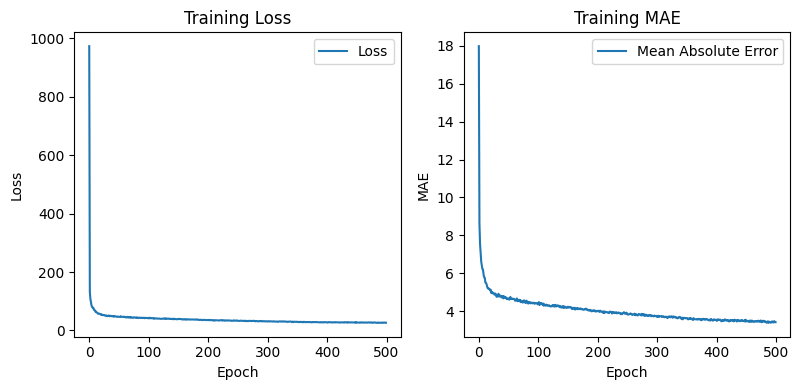

In [11]:
def custom_accuracy(y_true, y_pred, tolerance=0.1):
    # Calculate the absolute difference between predictions and true values
    diff = tf.abs(y_true - y_pred)
    # Check if the difference is within the tolerance level for each prediction
    within_tolerance = tf.less_equal(diff, tolerance * y_true)
    # Calculate mean accuracy across all dimensions
    return tf.reduce_mean(tf.cast(within_tolerance, tf.float32))

# Compile model with the custom accuracy metric
model.compile(optimizer='adam', loss='mse', metrics=['mae', custom_accuracy])

import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot mean absolute error (MAE)
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training MAE')
plt.legend()

# Plot custom accuracy (if defined)
if 'custom_accuracy' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['custom_accuracy'], label='Custom Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# Cargar el modelo previamente guardado
model = tf.keras.models.load_model("model_1.keras", custom_objects={'custom_accuracy': custom_accuracy})

# Preparar los datos de prueba
testA_data = testA_subject_to_photo_df.merge(testA_hwg_metadata_df, on='subject_id').merge(testA_measurements_df, on='subject_id')
testA_data['frontal_image_path'] = testA_mask_dir + '/' + testA_data['photo_id'] + '.png'
testA_data['lateral_image_path'] = testA_mask_left_dir + '/' + testA_data['photo_id'] + '.png'

# Generar predicciones
predictions = []
for _, row in testA_data.iterrows():
    if os.path.exists(row['frontal_image_path']) and os.path.exists(row['lateral_image_path']):
        frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=(224, 224), color_mode='grayscale')
        lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=(224, 224), color_mode='grayscale')

        # Convertir a arrays y concatenar en un input de 2 canales
        frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
        lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
        combined_image = np.concatenate([frontal_image, lateral_image], axis=-1) / 255.0  # Normalizar

        # Agregar height y weight como entradas adicionales
        additional_inputs = np.array([[row['height_cm'], row['weight_kg']]], dtype=np.float32)

        # Realizar la predicción
        pred = model.predict([np.expand_dims(combined_image, axis=0), additional_inputs])
        predictions.append([row['subject_id']] + pred[0].tolist())

# Crear un DataFrame con las predicciones
columns = ['subject_id', 'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
           'height', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']
pred_df = pd.DataFrame(predictions, columns=columns)

# Guardar las predicciones en un archivo CSV
pred_df.to_csv('predictions_testA.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# Cargar el modelo previamente guardado
model = tf.keras.models.load_model("model_1.keras", custom_objects={'custom_accuracy': custom_accuracy})

# Preparar los datos de prueba
testA_data = testA_subject_to_photo_df.merge(testA_hwg_metadata_df, on='subject_id').merge(testA_measurements_df, on='subject_id')
testA_data['frontal_image_path'] = testA_mask_dir + '/' + testA_data['photo_id'] + '.png'
testA_data['lateral_image_path'] = testA_mask_left_dir + '/' + testA_data['photo_id'] + '.png'

# Filtrar las filas donde las imágenes existen
testA_data = testA_data[testA_data['frontal_image_path'].apply(os.path.exists) & testA_data['lateral_image_path'].apply(os.path.exists)]

# Preparar las imágenes y entradas adicionales para todas las filas en un solo paso
images = []
additional_inputs = []

for _, row in testA_data.iterrows():
    # Cargar y procesar las imágenes frontal y lateral
    frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=(224, 224), color_mode='grayscale')
    lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=(224, 224), color_mode='grayscale')

    # Convertir a arrays y concatenar en un input de 2 canales
    frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
    lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
    combined_image = np.concatenate([frontal_image, lateral_image], axis=-1) / 255.0  # Normalizar
    images.append(combined_image)

    # Agregar height y weight como entradas adicionales
    additional_inputs.append([row['height_cm'], row['weight_kg']])

# Convertir a arrays numpy para usar en el modelo
images = np.array(images, dtype=np.float32)
additional_inputs = np.array(additional_inputs, dtype=np.float32)

# Realizar todas las predicciones de una sola vez
predictions = model.predict([images, additional_inputs])

# Crear un DataFrame con las predicciones
columns = ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'height', 'hip', 'leg-length',
           'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']
pred_df = pd.DataFrame(predictions, columns=columns)
pred_df['subject_id'] = testA_data['subject_id'].values  # Añadir los subject_id

# Guardar las predicciones en un archivo CSV
pred_df.to_csv('predictions_testA.csv', index=False)


53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step
